In [1]:
import keras
import datetime
import tensorflow                       as tf
from tensorflow.keras.callbacks         import TensorBoard
from tensorflow.keras.layers            import Input, Lambda, Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,concatenate,BatchNormalization, Activation
from tensorflow.keras.models            import Model
from tensorflow.keras.optimizers        import Adam
from keras.utils                        import plot_model
from tensorflow.keras                   import layers, models
from tensorflow.keras.losses            import mae
import sys
import os
import numpy as np
import math
import random, time
from pathlib                        import Path
from PIL                            import Image

import skimage                      as ski
from   skimage.filters              import threshold_otsu
from   skimage                      import io, color
from   skimage.color                import rgb2gray
from   skimage                      import filters
import cv2                          as cv
import matplotlib.pyplot            as plt 
import gc
import glob
from skimage                        import img_as_ubyte
from skimage                        import io
import shutil
tf.keras.backend.clear_session()

2025-05-09 14:53:54.566112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746816834.579563   23680 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746816834.583512   23680 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746816834.593541   23680 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746816834.593556   23680 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746816834.593557   23680 computation_placer.cc:177] computation placer alr

### Working with ImageDataGenerator

In [2]:
general_directory ='/home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5'

def dataset(directory,batch_size=32):
    data = keras.utils.image_dataset_from_directory(directory,
    labels=None,
    label_mode=None,
    image_size=(128, 256),
    color_mode="grayscale",
    shuffle=False,
    batch_size=batch_size)
    return data

path_1= general_directory + '/geo_masked' + '/train'
path_2= general_directory + '/geo_masked' + '/test'
path_3= general_directory + '/geo_masked' + '/valid'

path_4= general_directory + '/mag_masked' + '/train'
path_5= general_directory + '/mag_masked' + '/test'
path_6= general_directory + '/mag_masked' + '/valid'

path_7= general_directory + '/vx_masked' + '/train'
path_8= general_directory + '/vx_masked' + '/test'
path_9= general_directory + '/vx_masked' + '/valid'

path_10= general_directory + '/vy_masked' + '/train'
path_11= general_directory + '/vy_masked' + '/test'
path_12= general_directory + '/vy_masked' + '/valid'

path_13= general_directory + '/p_masked' + '/train'
path_14= general_directory + '/p_masked' + '/test'
path_15= general_directory + '/p_masked' + '/valid'
    

In [3]:
g_train = dataset(path_1)
g_test  = dataset(path_2)
g_valid = dataset(path_3)
print('******************')
v_train = dataset(path_4)
v_test  = dataset(path_5)
v_valid = dataset(path_6)
print('******************')
vx_train = dataset(path_7)
vx_test  = dataset(path_8)
vx_valid = dataset(path_9)
print('******************')
vy_train = dataset(path_10)
vy_test  = dataset(path_11)
vy_valid = dataset(path_12)
print('******************')
p_train = dataset(path_13)
p_test = dataset(path_14)
p_valid  = dataset(path_15)

Found 14000 files.
Found 2000 files.
Found 4000 files.


I0000 00:00:1746816841.576074   23680 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2118 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


******************
Found 14000 files.
Found 2000 files.
Found 4000 files.
******************
Found 14000 files.
Found 2000 files.
Found 4000 files.
******************
Found 14000 files.
Found 2000 files.
Found 4000 files.
******************
Found 14000 files.
Found 2000 files.
Found 4000 files.


In [4]:
# combination of output datasets
output_train = tf.data.Dataset.zip((v_train,vx_train,vy_train,p_train))
output_test = tf.data.Dataset.zip((v_test,vx_test,vy_test,p_test))
output_valid = tf.data.Dataset.zip((v_valid,vx_valid,vy_valid,p_valid))

# combination of input datasets with output datasets
final_train = tf.data.Dataset.zip((g_train,output_train))
final_test = tf.data.Dataset.zip((g_test,output_test))
final_valid = tf.data.Dataset.zip((g_valid,output_valid))

### Standarize the data

In [5]:
# Standardizing values to be in the [0, 1] range by using tf.keras.layers.Rescaling:
normalization_layer = tf.keras.layers.Rescaling(1./255)

final_train_normalized = final_train.map(lambda x, y: (normalization_layer(x), y))
final_test_normalized = final_test.map(lambda x, y: (normalization_layer(x), y))
final_valid_normalized = final_valid.map(lambda x, y: (normalization_layer(x), y))


### Hiperparámeters

In [12]:
num_epochs =3
patience=5  # How long to wait after last time validation loss improved
LR=0.001
# Model name
model="U-Net"
plot_name='U-Net_Model.png'
save_in='/home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5'
# image dimensions
img_width             =  256   # 739   G:737
img_height            =  128   # 185
channel               =  1

### Architecture

In [13]:

image_input = Input((img_height, img_width, channel))

# Encoder
c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(image_input)
c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
p1 = layers.MaxPooling2D((2, 2))(c1)

c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder
u4 = layers.UpSampling2D((2, 2))(c3)
u4 = layers.Concatenate()([u4, c2])
c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u4)
c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

u5 = layers.UpSampling2D((2, 2))(c4)
u5 = layers.Concatenate()([u5, c1])
c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u5)
conv9 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)


# **********************************************************************************************
# Construc  model
# final 1x1 convolutions to get to the correct depth dim (num_classes=4 for v, v-x, v-y, p)
output1 = Conv2D(1,(1,1),activation="relu", padding="same")(conv9)
#output1_masked = keras.layers.Multiply(name='output_v')([image_input, output1])

output2 = Conv2D(1,(1,1),activation="relu", padding="same")(conv9)
#output2_masked = keras.layers.Multiply(name='output_vx')([image_input, output2])

output3 = Conv2D(1,(1,1),activation="relu", padding="same")(conv9)
#output3_masked = keras.layers.Multiply(name='output_vy')([image_input, output3])

output4 = Conv2D(1,(1,1),activation="relu", padding="same")(conv9)
#output4_masked = keras.layers.Multiply(name='output_p')([image_input, output4])

#model = keras.Model(inputs=image_input, outputs=[output1_masked, output2_masked, output3_masked, output4_masked],name= 'U-Net')
model = keras.Model(inputs=image_input, outputs=[output1, output2, output3, output4],name= 'U-Net')

model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 128, 256,  │        160 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 128, 256,  │      2,320 │ conv2d_28[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 128,   │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 64, 128,   │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 64, 128,   │      9,248 │ conv2d_30[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 64,    │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 32, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 32, 64,    │     36,928 │ conv2d_32[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 64, 128,   │          0 │ conv2d_33[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 128,   │          0 │ up_sampling2d_4[… │
│ (Concatenate)       │ 96)               │            │ conv2d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 64, 128,   │     27,680 │ concatenate_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 64, 128,   │      9,248 │ conv2d_34[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 128, 256,  │          0 │ conv2d_35[0][0]   │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128, 256,  │          0 │ up_sampling2d_5[… │
│ (Concatenate)       │ 48)               │            │ conv2d_29[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 128, 256,  │      6,928 │ concatenate_5[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 128, 256,  │      2,320 │ conv2d_36[0][0] 

 Total params: 118,036 (461.08 KB)

 Trainable params: 118,036 (461.08 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(loss=['mse', 'mse', 'mse', 'mse'], optimizer='RMSprop', metrics=["mae","mae","mae","mae"])

print("Starting trainig")

history = model.fit(final_train,epochs=num_epochs,validation_data = final_valid)
   
model.compile(optimizer='RMSprop', 
              loss = {  'output_v': 'mean_squared_error' ,
                        'output_vx': 'mean_squared_error' , 
                        'output_vy': 'mean_squared_error',
                        'output_p': 'mean_squared_error'},
              
              metrics={ 'output_v': ['mae'],
                        'output_vx': ['mae'],
                        'output_vy': ['mae'],
                        'output_p': ['mae'] })

Starting trainig
Epoch 1/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 86s 190ms/step - conv2d_38_loss: 787.2215 - conv2d_38_mae: 19.1408 - conv2d_39_loss: 419.6448 - conv2d_39_mae: 14.4141 - conv2d_40_loss: 539.8147 - conv2d_40_mae: 15.2338 - conv2d_41_loss: 1173.4169 - conv2d_41_mae: 24.3370 - loss: 2920.1003 - val_conv2d_38_loss: 201.2651 - val_conv2d_38_mae: 10.3002 - val_conv2d_39_loss: 183.6731 - val_conv2d_39_mae: 9.7875 - val_conv2d_40_loss: 97.4462 - val_conv2d_40_mae: 8.1135 - val_conv2d_41_loss: 871.6285 - val_conv2d_41_mae: 21.7119 - val_loss: 1354.0132
Epoch 2/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 80s 183ms/step - conv2d_38_loss: 193.9964 - conv2d_38_mae: 9.7861 - conv2d_39_loss: 181.8207 - conv2d_39_mae: 9.4632 - conv2d_40_loss: 92.7521 - conv2d_40_mae: 7.1237 - conv2d_41_loss: 883.8347 - conv2d_41_mae: 20.7426 - loss: 1352.4042 - val_conv2d_38_loss: 157.4632 - val_conv2d_38_mae: 8.3784 - val_conv2d_39_loss: 147.0276 - val_conv2d_39_mae: 8.1394 - val_conv2d_40_loss: 75.6050 - val_conv2d_40_mae

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


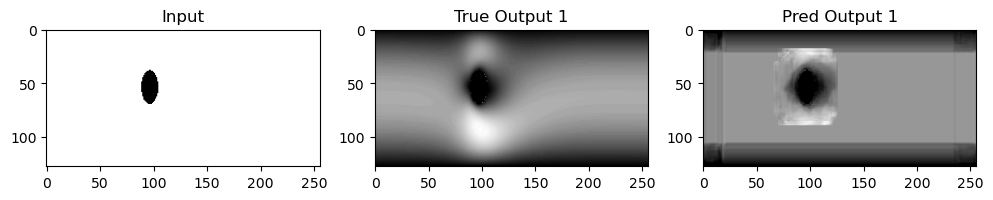

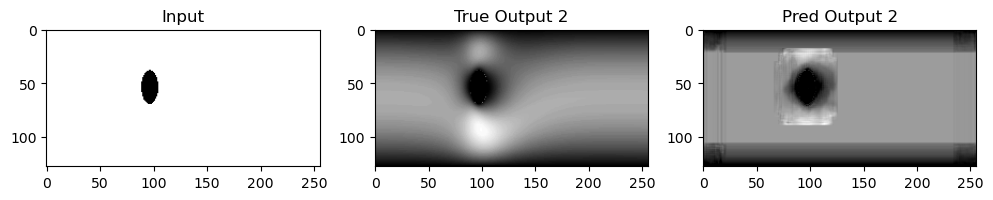

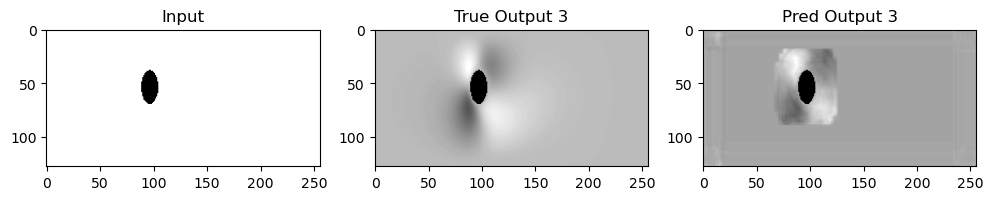

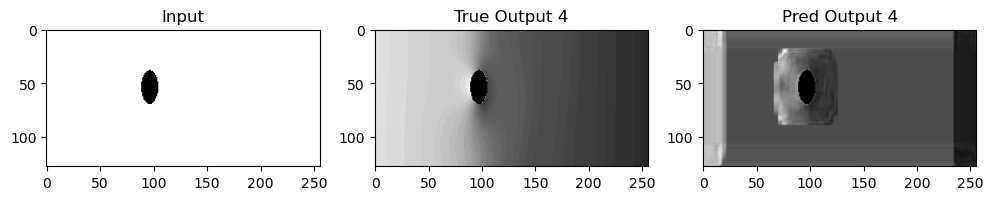

In [17]:
for x_test,y_true in final_test.take(1):
    y_pred = model.predict(x_test)
    for i in range(4):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(x_test[0],cmap='gray')
        axs[0].set_title("Input")

        axs[1].imshow(y_true[i][0],cmap='gray')
        axs[1].set_title(f"True Output {i+1}")

        axs[2].imshow(y_pred[i][0],cmap='gray')
        axs[2].set_title(f"Pred Output {i+1}")
        plt.show()
        